In [1]:
!pip install pymorphy2
!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import pymorphy2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re

from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
morph = pymorphy2.MorphAnalyzer()

stop_words = get_stop_words('ru')

Выбранный мной датасет ставит задачу классификации текстов, имеет только один текстовых признак. Тексты не обработаны: в них присутствуют знаки препинания, стоп-слова (служебные части речи) и опечатки.

In [4]:
df = pd.read_csv('women-clothing-accessories.3-class.balanced.csv', sep='	')
df

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative
...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,positive
89996,Накидка шикарная. Спасибо большое провдо линяе...,positive
89997,спасибо большое ) продовца рекомендую.. заказа...,positive
89998,Очень довольна заказом! Меньше месяца в РБ. К...,positive


Целевой переменной является sentiment, которая может принимать 3 значения (негативный, нейтральный, позитивный)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


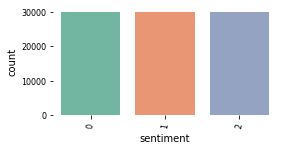

In [5]:
df['sentiment'] = pd.factorize(df['sentiment'])[0]

plt.figure(figsize=(4,2))

sns.countplot(df['sentiment'],
              palette=sns.color_palette('Set2', 25))

plt.xticks(size=8,rotation=80)
plt.yticks(size=8)
sns.despine(bottom=True, left=True)
plt.show()

Датасет сбаланирован, каждый класс встречается по 30 тыс. раз<br>
Пропусков нет

### Функция для очистки и лемматизации текста

При помощи регулярного выражения вытаскиваем все слова, кроме стоп-слов, а после лемматизируем их (приводим в начальную форму).<br> Для лемматизации я использую pymorphy2, основанный на статистическом анализе. Этот метод не самый точный, но сравнительно быстрый

In [6]:
def clear_text(text):
    text = re.findall(r'[а-яё]+', text.lower())
    normalized = []
    for word in text:
        if word in stop_words:
            continue
        word = morph.parse(word)[0][2]
        normalized.append(word)
    fixed = ' '.join(normalized)
    return fixed

In [7]:
tqdm.pandas()

df['clear_text'] = ''
df['clear_text'] = df['review'].progress_apply(lambda x: clear_text(x))
df

  0%|          | 0/90000 [00:00<?, ?it/s]

,review,sentiment,clear_text
0,качество плохое пошив ужасный (горловина напер...,0,качество плохой пошив ужасный горловина напере...
1,"Товар отдали другому человеку, я не получила п...",0,товар отдать другой человек получить посылка л...
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0,ужасный синтетик тонкий общий представить карт...
3,"товар не пришел, продавец продлил защиту без м...",0,товар прийти продавец продлить защита мой согл...
4,"Кофточка голая синтетика, носить не возможно.",0,кофточка голый синтетик носить возможно
...,...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,2,сделать достаточно ткань сделать рисунок замет...
89996,Накидка шикарная. Спасибо большое провдо линяе...,2,накидка шикарный большой провдо линять немножк...
89997,спасибо большое ) продовца рекомендую.. заказа...,2,большой продовца рекомендовать заказать прийти
89998,Очень довольна заказом! Меньше месяца в РБ. К...,2,довольный заказ месяц рб курьер привезти домой...


Я решил посмотреть на распределение по длине текстов для каждого класса. Как можно видеть ниже, у всех классов большинство текстов не превышают длину 40 слов, а мода находится между 6 и 8 словами<br>Далее я планирую использовать усредненные семантические вектора, поэтому дальнейший количественный анализ текстов не имеет смысла

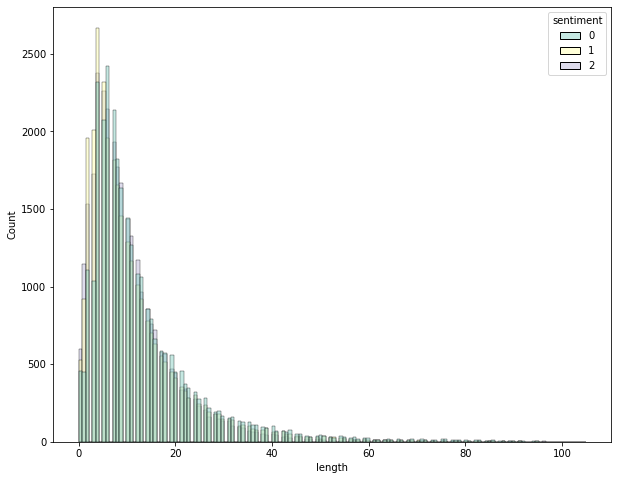

In [8]:
plt.figure(figsize=(10,8))
df['length'] = df['clear_text'].apply(lambda x: len(x.split()))  #распределение текстов по длинам 
ax = sns.histplot(data=df, x='length', bins=150, hue='sentiment', palette='Set3')
plt.show()

Применение модели эмбедингов для русского языка (https://github.com/natasha/navec), для каждой фразы берется среднее значение для всех токенов, если модель не содержит вектор хотя бы одного токена в фразе, то возвращается нулевой вектор <br>Модель весит 25мб, поэтому вектора получаются довольно быстро.

In [9]:
!pip install navec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from navec import Navec

navec = Navec.load('navec_news_v1_1B_250K_300d_100q.tar')

In [11]:
def get_phrase_embedding(text):
    vector = []
    text = text.split(' ')
    for word in text:
        try:
            word_vec = navec[word]
        except KeyError:
            continue
        vector.append(word_vec)
    if not len(vector):
        vector = np.zeros(300).astype(np.float32)
    else:
        vector = np.mean(np.array(vector), axis=0)
    return vector

In [12]:
df['vector'] = ''
df['vector'] = df['clear_text'].progress_apply(lambda x: get_phrase_embedding(x))
df

  0%|          | 0/90000 [00:00<?, ?it/s]

,review,sentiment,clear_text,length,vector
0,качество плохое пошив ужасный (горловина напер...,0,качество плохой пошив ужасный горловина напере...,17,"[0.20227769, 0.15029465, -0.03365564, 0.082827..."
1,"Товар отдали другому человеку, я не получила п...",0,товар отдать другой человек получить посылка л...,9,"[0.0030338352, 0.024449788, -0.08635155, 0.259..."
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0,ужасный синтетик тонкий общий представить карт...,16,"[0.10217319, -0.21782476, -0.003937324, 0.1218..."
3,"товар не пришел, продавец продлил защиту без м...",0,товар прийти продавец продлить защита мой согл...,10,"[0.2101756, 0.16568482, -0.020004356, 0.073962..."
4,"Кофточка голая синтетика, носить не возможно.",0,кофточка голый синтетик носить возможно,5,"[0.001278927, -0.37000084, 0.38495457, 0.09426..."
...,...,...,...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,2,сделать достаточно ткань сделать рисунок замет...,10,"[-0.044707496, 0.038559306, -0.013525968, 0.20..."
89996,Накидка шикарная. Спасибо большое провдо линяе...,2,накидка шикарный большой провдо линять немножк...,13,"[-0.06941178, -0.13470426, -0.14100493, 0.0281..."
89997,спасибо большое ) продовца рекомендую.. заказа...,2,большой продовца рекомендовать заказать прийти,5,"[0.11368352, -0.093126826, -0.004453942, 0.124..."
89998,Очень довольна заказом! Меньше месяца в РБ. К...,2,довольный заказ месяц рб курьер привезти домой...,11,"[-0.021646515, -0.06802372, -0.027957423, 0.12..."


В итоге я получил для каждого текста семантический вектор размерностью 300, все значения в этих векторах изначально нормализованны, поэтому дальнейшая их обработка не требуется

Поскольку эта задача учебная, я решил остановиться только на среднем семантическом векторе, однако для улучшения качества можно посчитать другие статистические признаки (длина текста, средння длина токена, частеречное распределение слов в тексте, распределение синтаксических отношений, readability metrics и т.д.)

## Деление на трейн и тест

In [13]:
X, y = df['vector'].tolist(), df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
X_train.shape

(72000, 300)

## KNN

Из-за размера датасета (72к, 300) я решил не обучать KNN и SVC, потому что это занимает слишком много времени, но я оставил код

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=10)
KNN_model.fit(X_train, y_train)

In [ ]:
y_pred  = KNN_model.predict(X_test)    
print(f'SVC train: {KNN_model.score(X_test, y_test)}\nSVC test: {KNN_model.score(X_train, y_train)}')

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

## SVC


In [14]:
from sklearn.svm import SVC

In [ ]:
SVC_model = SVC()
SVC_model.fit(X_train, y_train)

In [ ]:
y_pred  = SVC_model.predict(X_test)    
print(f'SVC train: {SVC_model.score(X_test, y_test)}\nSVC test: {SVC_model.score(X_train, y_train)}')

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

## LOGREG

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [18]:
y_pred = logreg.predict(X_test)
print(f'LOGREG train: {logreg.score(X_test, y_test)}\nLOGREG test: {logreg.score(X_train, y_train)}')

LOGREG train: 0.6703333333333333
LOGREG test: 0.6746527777777778


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.65      0.67      5942
           1       0.56      0.59      0.58      6060
           2       0.78      0.76      0.77      5998

    accuracy                           0.67     18000
   macro avg       0.67      0.67      0.67     18000
weighted avg       0.67      0.67      0.67     18000



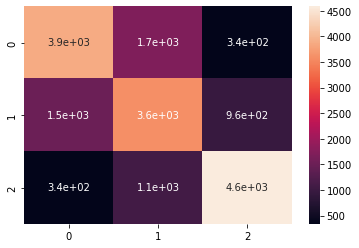

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

## LINREG

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [25]:
y_pred = linreg.predict(X_test)
print(f'Tree train: {linreg.score(X_test, y_test)}\nTree test: {linreg.score(X_train, y_train)}')

Tree train: 0.4314310479990433
Tree test: 0.4373450318541142


In [28]:
def round_lin_reg(element):
  if element < 0.5:
    element = 0
  elif element >= 1.5:
    element = 2
  else:
    element = 1
  return element

y_pred = [round_lin_reg(i) for i in y_pred]

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.39      0.51      5942
           1       0.42      0.81      0.55      6060
           2       0.87      0.45      0.59      5998

    accuracy                           0.55     18000
   macro avg       0.67      0.55      0.55     18000
weighted avg       0.67      0.55      0.55     18000



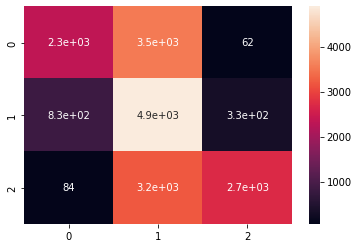

In [30]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

## Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [33]:
y_pred = tree.predict(X_test)
print(f'Tree train: {tree.score(X_test, y_test)}\nTree test: {tree.score(X_train, y_train)}')

Tree train: 0.5418888888888889
Tree test: 0.5485138888888889


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.50      0.55      5942
           1       0.45      0.55      0.49      6060
           2       0.61      0.57      0.59      5998

    accuracy                           0.54     18000
   macro avg       0.56      0.54      0.54     18000
weighted avg       0.56      0.54      0.54     18000



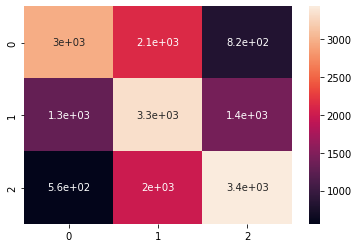

In [35]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rfc = RandomForestClassifier(max_depth=5, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [38]:
y_pred = rfc.predict(X_test)
print(f'Forest train: {rfc.score(X_test, y_test)}\nForest test: {rfc.score(X_train, y_train)}')

Forest train: 0.6031666666666666
Forest test: 0.6126944444444444


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.51      0.58      5942
           1       0.50      0.59      0.54      6060
           2       0.67      0.71      0.69      5998

    accuracy                           0.60     18000
   macro avg       0.61      0.60      0.60     18000
weighted avg       0.61      0.60      0.60     18000



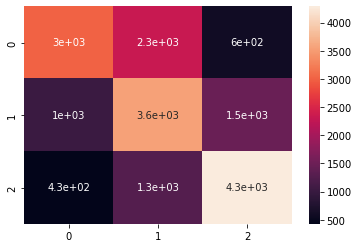

In [42]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

## Neural Network

In [56]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [53]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(len(X_train[0])))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                19264     
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 19,459
Trainable params: 19,459
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=.2)

Epoch 1/10
450/450 [==============================] - 2s 3ms/step - loss: 0.7988 - accuracy: 0.6391 - val_loss: 0.7435 - val_accuracy: 0.6723
Epoch 2/10
450/450 [==============================] - 1s 3ms/step - loss: 0.7383 - accuracy: 0.6719 - val_loss: 0.7299 - val_accuracy: 0.6768
Epoch 3/10
450/450 [==============================] - 1s 3ms/step - loss: 0.7221 - accuracy: 0.6783 - val_loss: 0.7212 - val_accuracy: 0.6774
Epoch 4/10
450/450 [==============================] - 1s 3ms/step - loss: 0.7115 - accuracy: 0.6847 - val_loss: 0.7143 - val_accuracy: 0.6832
Epoch 5/10
450/450 [==============================] - 1s 3ms/step - loss: 0.7018 - accuracy: 0.6879 - val_loss: 0.7133 - val_accuracy: 0.6844
Epoch 6/10
450/450 [==============================] - 1s 3ms/step - loss: 0.6941 - accuracy: 0.6922 - val_loss: 0.7076 - val_accuracy: 0.6837
Epoch 7/10
450/450 [==============================] - 1s 3ms/step - loss: 0.6866 - accuracy: 0.6946 - val_loss: 0.7064 - val_accuracy: 0.6847
Epoch 

In [57]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

563/563 [==============================] - 1s 1ms/step


In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      5942
           1       0.59      0.53      0.56      6060
           2       0.75      0.81      0.78      5998

    accuracy                           0.68     18000
   macro avg       0.68      0.68      0.68     18000
weighted avg       0.68      0.68      0.68     18000



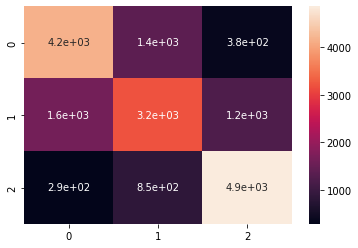

In [59]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

## Вывод


Ключевой метрикой я решил считать f1 marco avg.

* Лучше всего себя проявила нейронная сеть с одним скрытым слоем - 0.68
* Практически идентичный результат показал LogReg, но стоит учитывать, что он обучался на большем количестве данных - 0.67
* Случайный лес показал результат 0.6
* LinReg показал результат 0.55
* Дерево решений - 0.54

Метрики для KNN и SVC не считались<br>
Можно сказать, что задача классификации решена. Больше всего ошибок все модели совершают с определением нейтрального класса (1). Для улучшения можно попробовать увеличить количесвто параметров, добавив статистические данные о тексте. 

